# Chapter Post Hoc 1: Classification models with MC-Dropout
The aim of this chapter is to present a classification model using the integration of dropout (as a regularisation technique) and MC dropout as a post-hoc uncertainty estimation technique.

In [17]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

# SPH1-1: Classification model
We want to introduce an elementary classification model on the provided dataset.

First we define the device:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Read the existing database and subdivide it in training/validation/test:

In [3]:
chosen_df = "df_classification.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

print("Dataframe length:", len(full_df))
print("Training length:", len(training_df))
print("Validation length:", len(validation_df))
print("Test length:", len(test_df))

full_df.head(8)

Dataframe length: 1050
Training length: 800
Validation length: 100
Test length: 150


,x_range,y_range,split_label,label
0,-100.000000,-2.898434,0,1
1,-99.799800,-1.558429,0,0
2,-99.599600,-2.539175,0,1
3,-99.399399,-0.734771,0,0
4,-99.199199,-0.595149,0,0
5,-98.998999,-1.210294,0,0
6,-98.798799,-2.450978,1,1
7,-98.598599,-0.601458,0,0


Show the scatterplots of the training and test dataframe:

<Axes: xlabel='x_range', ylabel='y_range'>

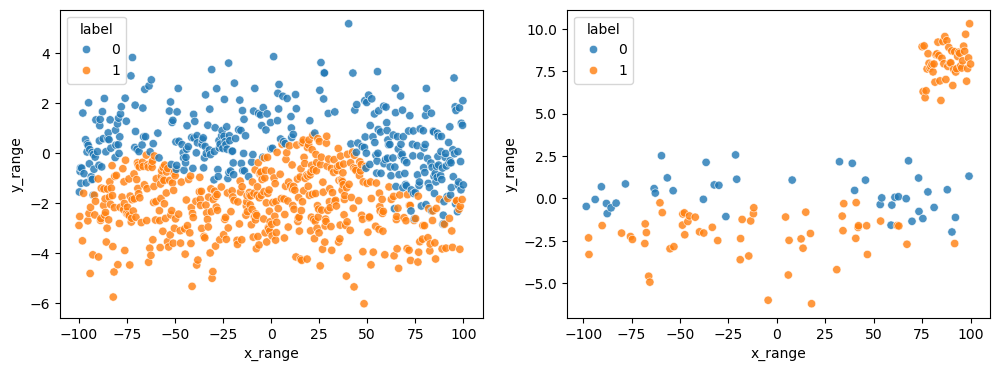

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

# Scatter plot
sns.scatterplot(data=training_df, x="x_range", y="y_range", hue="label", alpha = 0.8, ax = axs[0])
sns.scatterplot(data=test_df, x="x_range", y="y_range", hue="label", alpha = 0.8, ax = axs[1])

Define a custom dataset that returns a feature vector (in this case (x,y)) and a label (seconded as torch.long()):

In [5]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])
        features = torch.tensor([x_range, y_range], dtype=torch.float32)
        
        label = self.df.iloc[idx]['label']

        return features, torch.tensor(label, dtype=torch.long)

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example ([x_range,y_range],label)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 800
Output example ([x_range,y_range],label)=((tensor([-92.7928,  -4.0742]), tensor(1))) with index 27.


Define the dataloaders from the CustomDataset:

In [6]:
# Size of each batch
batch_size = 10 

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The model is defined as a sequential PyTorch model with 2 inputs (x,y) and 2 outputs (class 0, class 1). The two outputs are returned as "logits", intended to be real-valued numbers.

The model implements dropout layers, which drop (i.e. set to 0) a percentage of the previous layer's inputs at each *training* iteration.
In this way, each training step focuses on a different subset of weights and tries to avoid getting stuck in local minima.

In [7]:
# Decide the dropout parameter
p_drop = 0.5

# Define the model:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Dropout(p_drop),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Dropout(p_drop),
    nn.Linear(4, 2)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

The loss for (multi-class) classification is the Cross Entropy Loss. In pytorch, it can be defined as a softmax layer followed by a logarithmic transformation and an NLL loss, or it can be computed directly using the CrossEntropyLoss. This second approach involves a computational trick to stabilise the backpropagation.

In [8]:
# Loss function (Cross entropy loss):
loss_fn = nn.CrossEntropyLoss() # It applies log_softmax and NLL directly

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle:

In [9]:
# Number of training epochs:
n_epochs = 100

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for xy_input, label_gt in training_dataloader:
        # Load inputs ad move to device (GPU)
        xy_input, label_gt = xy_input.to(device), label_gt.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        logits_model = model(xy_input)  

        # Compute loss (supervised case)
        loss = loss_fn(logits_model, label_gt)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for xy_input, label_gt in validation_dataloader:
            # Load inputs ad move to device (GPU)
            xy_input, label_gt = xy_input.to(device), label_gt.to(device)

            # Forward pass (model calls)
            logits_model = model(xy_input)

            # Compute loss (supervised case)
            loss = loss_fn(logits_model, label_gt)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/100], Loss: 1.2562, Val. Loss: 0.6708
Epoch [2/100], Loss: 0.9506, Val. Loss: 0.6742
Epoch [3/100], Loss: 0.8869, Val. Loss: 0.6748
Epoch [4/100], Loss: 0.7827, Val. Loss: 0.6752
Epoch [5/100], Loss: 0.7415, Val. Loss: 0.6729
Epoch [6/100], Loss: 0.7126, Val. Loss: 0.6732
Epoch [7/100], Loss: 0.6958, Val. Loss: 0.6700
Epoch [8/100], Loss: 0.6914, Val. Loss: 0.6658
Epoch [9/100], Loss: 0.6867, Val. Loss: 0.6630
Epoch [10/100], Loss: 0.6667, Val. Loss: 0.6572
Epoch [11/100], Loss: 0.6794, Val. Loss: 0.6544
Epoch [12/100], Loss: 0.6709, Val. Loss: 0.6515
Epoch [13/100], Loss: 0.6521, Val. Loss: 0.6439
Epoch [14/100], Loss: 0.6612, Val. Loss: 0.6377
Epoch [15/100], Loss: 0.6539, Val. Loss: 0.6310
Epoch [16/100], Loss: 0.6511, Val. Loss: 0.6261
Epoch [17/100], Loss: 0.6500, Val. Loss: 0.6213
Epoch [18/100], Loss: 0.6467, Val. Loss: 0.6142
Epoch [19/100], Loss: 0.6371, Val. Loss: 0.6061
Epoch [20/100], Loss: 0.6372, Val. Loss: 0.6011
Epoch [21/100], Loss: 0.6486, Val. Loss: 0.5991
E

Plots the convergence curves (training and validation losses):

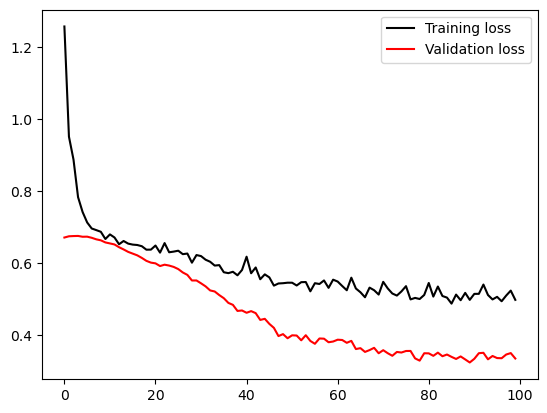

In [10]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

Dropout layers are disabled in "Evaluation Mode" to avoid different output each time the model is called.

When the model is used in "Training Mode", the dropout layers randomly select a percentage of nodes to keep and set the others to zero. The retained nodes are multiplied by a scaling factor to ensure consistency of mean values for subsequent layers.

In [11]:
# Define a possible input:
x_example = 25
y_example = 0
xy_example = torch.tensor([x_example, y_example], dtype=torch.float32)
xy_example = xy_example.to(device)


## With deactivated dropout layers
model.eval()

# Forward pass (model calls)
logits_model = model(xy_example)

# Select the highest value among possible logits
predicted_class = torch.argmax(logits_model)
print("Deactivated Dropout Layers:")
print("Logits: ", logits_model)
print("Predicted class: ", predicted_class)


## With ACTIVATED dropout layers
model.train()

# Forward pass (model calls)
logits_model = model(xy_example)

# Select the highest value among possible logits
predicted_class = torch.argmax(logits_model)
print("Activated Dropout Layers:")
print("Logits: ", logits_model)
print("Predicted class: ", predicted_class)

Deactivated Dropout Layers:
Logits:  tensor([-0.2679, -0.0422], device='cuda:0', grad_fn=<ViewBackward0>)
Predicted class:  tensor(1, device='cuda:0')
Activated Dropout Layers:
Logits:  tensor([-0.2679, -0.0422], device='cuda:0', grad_fn=<ViewBackward0>)
Predicted class:  tensor(1, device='cuda:0')


To convert model outputs (i.e. a 2-dimensional vector of logits $\in \mathbb{R}^2$) into a classification result, we can select the class corresponding to the node with the higher value:

In [12]:
# Use the model in evaluation mode:
model.eval()

# Define a list of predictions:
list_label_prediction = []

# Iterates without computing gradients:
with torch.no_grad():
    # Make a prediction for each training/validation/test inputs:
    for i in range(len(full_df)):
        # Select the row/inputs for each index, convert to float32 tensor and move to the device
        row = full_df.iloc[i]
        x_range = row["x_range"]
        y_range = row["y_range"]
        xy_input =  torch.tensor([x_range, y_range], dtype=torch.float32)
        xy_input = xy_input.to(device)

        # Forward pass (model calls)
        logits_model = model(xy_input)

        # Select the highest value among possible logits
        predicted_class = torch.argmax(logits_model)

        # Append the prediction to the list:
        list_label_prediction.append(int(predicted_class.to('cpu')))

The MC dropout requires resampling the ANN using the dropout layers (i.e., by keeping the Training Mode during inference) a given number of time. 

Then we can select the most common outputs or, viceversa, define a dispersion score based on logits variability.

In [18]:
# Use the model in training mode (MC Dropout):
model.train()
n_samples = 50

# Define a list of predictions:
list_MC_label_prediction = []
list_MC_label_dispersion = []

# Iterates without computing gradients:
with torch.no_grad():
    # Make a prediction for each training/validation/test inputs:
    for i in tqdm(range(len(full_df))):
        # Select the row/inputs for each index, convert to float32 tensor and move to the device
        row = full_df.iloc[i]
        x_range = row["x_range"]
        y_range = row["y_range"]
        xy_input =  torch.tensor([x_range, y_range], dtype=torch.float32)
        xy_input = xy_input.to(device)

        # Sample n_samples time the model:
        tmp_MC_label_prediction = []
        for s in range(n_samples):
            # Forward pass (model calls)
            logits_model = model(xy_input)
    
            # Select the highest value among possible logits
            predicted_class = torch.argmax(logits_model)

            # Append the temporary prediction
            tmp_MC_label_prediction.append(int(predicted_class.to('cpu')))

        # Define the MC prediction as the average (there are several possibilities)
        list_MC_label_prediction.append(int(np.median(tmp_MC_label_prediction)))
        # Define the MC dispersion as the std (there are several possibilities)
        list_MC_label_dispersion.append(np.std(tmp_MC_label_prediction))

100%|██████████| 1050/1050 [00:27<00:00, 38.68it/s]


Define a dataframe and plot the predictions and GT. As expected, the predictions become blurred near the boundary and the whole set of OOD data (top right) is incorrectly labelled.

We added a secundary plot with the MC predictions.

The third plot shows unreliable predictions to the respect of MC dropout. It can be seen that most of the removed points correspond to wrong predictions.

The fourth plot shows reliable predictions.

Text(0.5, 1.0, 'Low dispersion')

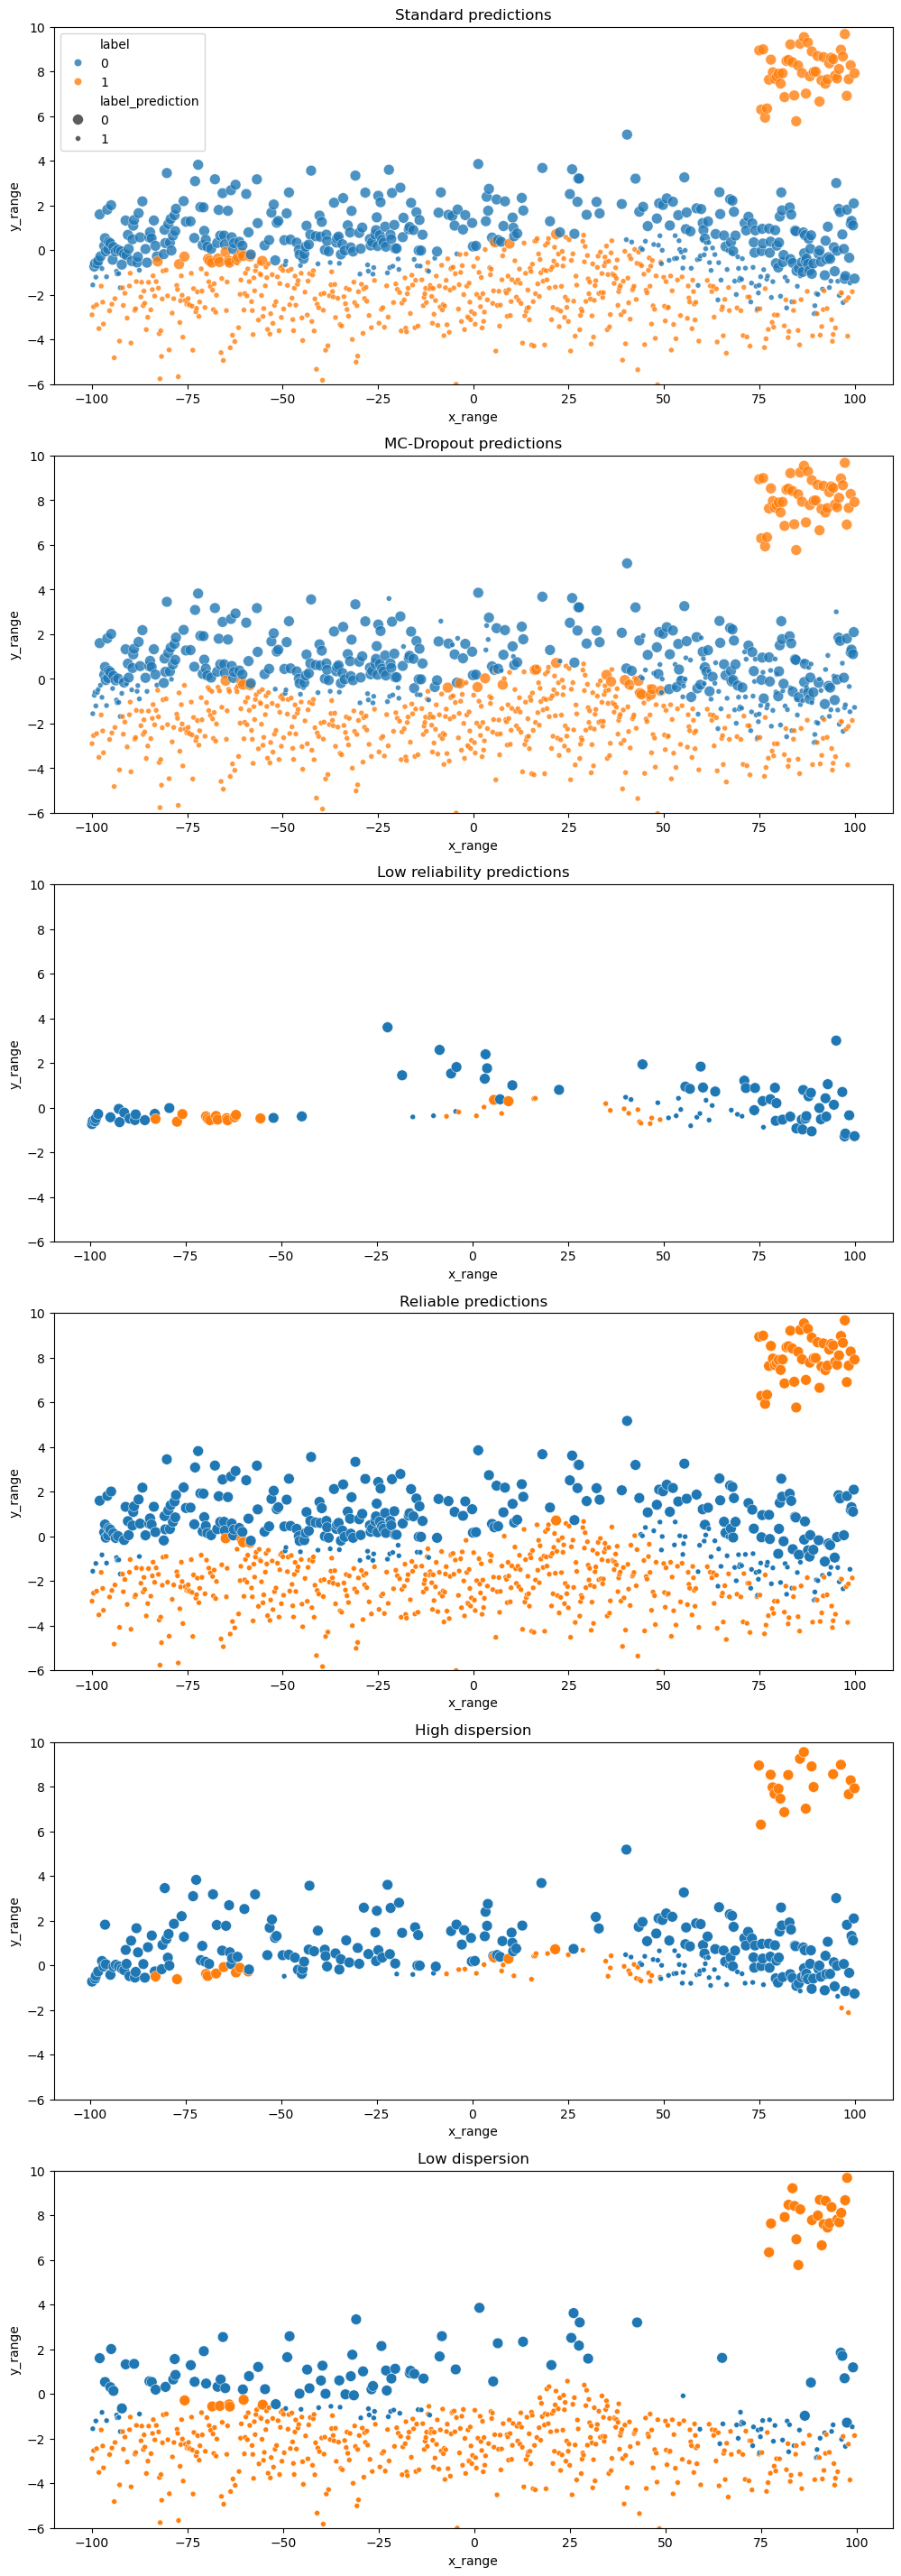

In [19]:
# Define an additional dataframe and add the previously calculated predictions
additional_df = full_df
additional_df['label_prediction'] = list_label_prediction 
additional_df['MC_label_prediction'] = list_MC_label_prediction 

#list_MC_label_dispersion_alpha = [1 if i>0 else 0 for i in list_MC_label_dispersion]
list_discrepancy = [1 if additional_df['label_prediction'][i]!=additional_df['MC_label_prediction'][i] else 0 for i in range(len(additional_df))]
additional_df['list_discrepancy'] =  list_discrepancy
additional_df['dispersion'] =  list_MC_label_dispersion

# Scatter plot
fig, axs = plt.subplots(6,1, figsize = (12,36))
sns.scatterplot(data=additional_df, x="x_range", y="y_range", hue="label", size = "label_prediction", alpha = 0.8, ax=axs[0])
axs[0].set_ylim(-6, 10)
axs[0].set_title("Standard predictions")

sns.scatterplot(data=additional_df, x="x_range", y="y_range", hue="label", size = "MC_label_prediction", alpha = 0.8, ax=axs[1])
axs[1].set_ylim(-6, 10)
axs[1].get_legend().remove()
axs[1].set_title("MC-Dropout predictions")

sns.scatterplot(data=additional_df[additional_df['list_discrepancy']==1], x="x_range", y="y_range", hue="label", size = "label_prediction", ax=axs[2])
axs[2].set_ylim(-6, 10)
axs[2].get_legend().remove()
axs[2].set_title("Low reliability predictions")

sns.scatterplot(data=additional_df[additional_df['list_discrepancy']!=1], x="x_range", y="y_range", hue="label", size = "label_prediction", ax=axs[3])
axs[3].set_ylim(-6, 10)
axs[3].get_legend().remove()
axs[3].set_title("Reliable predictions")

sns.scatterplot(data=additional_df[additional_df['dispersion']>0.48], x="x_range", y="y_range", hue="label", size = "label_prediction", ax=axs[4])
axs[4].set_ylim(-6, 10)
axs[4].get_legend().remove()
axs[4].set_title("High dispersion")

sns.scatterplot(data=additional_df[additional_df['dispersion']<0.48], x="x_range", y="y_range", hue="label", size = "label_prediction", ax=axs[5])
axs[5].set_ylim(-6, 10)
axs[5].get_legend().remove()
axs[5].set_title("Low dispersion")